# **Teste de Hipótese Aplicando ao Mercado Financeiro**

## **Teste de Hipótese sobre duas médias populacionais**

* $\sigma{1}$ e $\sigma{2}$ são conhecidos 
* Amostras Independentes


$
Z = \frac{(x_1 - x_2)}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}
$


### A idéia do código é comparar retornos de dois períodos diferentes utilizando conceitos de teste de hipótese

In [1]:
# Imports

import pandas as pd
import numpy as np
import yfinance as yf
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter # formatar a data no eixo x 
import matplotlib.gridspec as gridspec # subplots com tamanhos diferentes
plt.style.use('seaborn-v0_8-darkgrid') # mudar o estilo do matplotlib
from datetime import datetime, timedelta
import requests


get_ipython().run_line_magic("matplotlib", "inline")
import warnings
warnings.filterwarnings("ignore")

## Coletando os dados 

In [2]:
# funçao para obter dados históricos da binance
def get_klines(symbol, interval, limit = 360):
    url = 'https://api.binance.com./api/v3/klines'
    params = {'symbol': symbol, 'interval': interval, 'limit': limit}
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data, 
                      columns = ['timestamp', 'open','high','low','Close','volume',
                                '-','-','-','-','-','-'
                                ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df['Close'] = df['Close'].astype(float)

    # Retornos
    df["Returns"] = df["Close"].pct_change(1)

    return df[['Close', 'Returns']]

In [3]:
TICKER = 'BTCUSDT' # Ticker a ser utilizado

df1 = get_klines(TICKER, '1d', 360)

# Ajudando o index 
df1 = df1.reset_index()
df1.rename(columns={'timestamp': 'Date'}, inplace=True)
df1.set_index('Date', inplace=True)


print(df1.head())

               Close   Returns
Date                          
2024-07-03  60208.58       NaN
2024-07-04  57050.01 -0.052460
2024-07-05  56628.79 -0.007383
2024-07-06  58230.13  0.028278
2024-07-07  55857.81 -0.040740


In [4]:
df1["Returns"] = df1["Close"].pct_change(1)
df1["Target"] = df1["Returns"].shift(-1)
df1.head()

,Close,Returns,Target
Date,,,
2024-07-03,60208.58,NaN,-0.052460
2024-07-04,57050.01,-0.052460,-0.007383
2024-07-05,56628.79,-0.007383,0.028278
2024-07-06,58230.13,0.028278,-0.040740
2024-07-07,55857.81,-0.040740,0.015339


## Separando os dados das amostras

In [5]:
N_DIAS = 30 # Número de dias a serem avaliados para cada grupo 

LAG_DAYS = N_DIAS*2 # Números de dias de lags a serem criados 

# Criando as colunas de lag para os retornos
for i in range(LAG_DAYS):
    df1[f'lag_{i+1}'] = df1['Returns'].shift(i+1)

In [6]:
df1.tail()

,Close,Returns,Target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-23,105333.93,0.043283,0.007111,-0.011321,-0.011404,-0.013000,-0.002176,0.003210,-0.021006,0.011369,...,-0.010638,0.004117,0.024614,-0.000900,-0.007940,0.013460,-0.009286,-0.000113,0.007004,0.003089
2025-06-24,106083.00,0.007111,0.011855,0.043283,-0.011321,-0.011404,-0.013000,-0.002176,0.003210,-0.021006,...,-0.016470,-0.010638,0.004117,0.024614,-0.000900,-0.007940,0.013460,-0.009286,-0.000113,0.007004
2025-06-25,107340.58,0.011855,-0.003666,0.007111,0.043283,-0.011321,-0.011404,-0.013000,-0.002176,0.003210,...,0.004837,-0.016470,-0.010638,0.004117,0.024614,-0.000900,-0.007940,0.013460,-0.009286,-0.000113
2025-06-26,106947.06,-0.003666,0.001029,0.011855,0.007111,0.043283,-0.011321,-0.011404,-0.013000,-0.002176,...,0.022171,0.004837,-0.016470,-0.010638,0.004117,0.024614,-0.000900,-0.007940,0.013460,-0.009286
2025-06-27,107057.13,0.001029,NaN,-0.003666,0.011855,0.007111,0.043283,-0.011321,-0.011404,-0.013000,...,0.002029,0.022171,0.004837,-0.016470,-0.010638,0.004117,0.024614,-0.000900,-0.007940,0.013460


## Cálculo do valor Z 

Serão calculadas as médias e variâncias de duas amostras contendo N_DIAS dias,
então será calculado o valor Z e a sua região crítica baseado em $\alpha$


In [7]:
# calculando a variância dos períodos
df1['var_1']  = df1.iloc[:, 3+N_DIAS:3+(N_DIAS*2)].var(axis=1)
df1['var_2']  = df1.iloc[:, 3:3+N_DIAS].var(axis=1) 

# Cálculo da médias 
df1['mean_1'] = df1.iloc[:, 3+N_DIAS: 3+(N_DIAS*2)].mean(axis = 1)
df1['mean_2'] = df1.iloc[:, 3: 3+N_DIAS].mean(axis = 1)

In [8]:
# teste de hipótese para média 
df1['z'] = np.round((df1['mean_1'] - df1['mean_2'])/ np.sqrt((df1['var_1']/LAG_DAYS*0.5)+(df1['var_2']/LAG_DAYS*0.5)),2)


# Valores críticos
from scipy.stats import norm

#GRAUS_LIBERDADE = LAG_DAYS*2 - 2  # Graus de liberdade para o teste t

ALPHA = 0.05  # Nível de significância

# Valores críticos para o teste z
X_CRIT_1 = np.round(norm.ppf(1 - ALPHA),2)  # 95% confidence level, two-tailed test
X_CRIT_2 = np.round(X_CRIT_1 * (-1),2)

In [9]:
print('Região Crítica:')
print(f'Valore maiores que: {X_CRIT_1}')
print(f'Valore menores que: {X_CRIT_2}')

Região Crítica:
Valore maiores que: 1.64
Valore menores que: -1.64


## Gráficos 

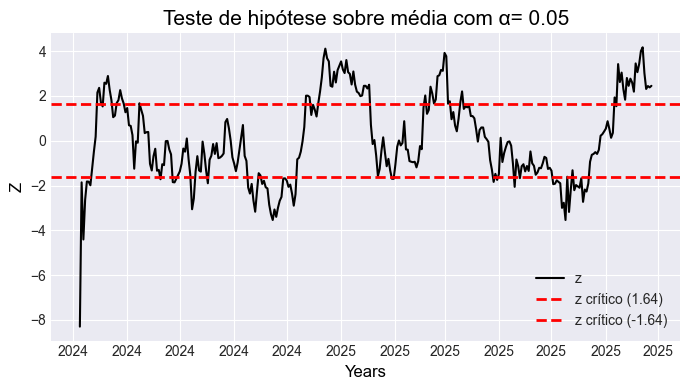

In [10]:
# criando o gráfico
fig, ax = plt.subplots(figsize=(7, 4))

# plot do valor z 
ax.plot(df1.index, df1['z'], color='black', label='z')

# Adicionando linhas horizontais para os valores críticos
ax.axhline(y=X_CRIT_1, color='red', linestyle='--', linewidth=2, label=f'z crítico ({X_CRIT_1})')
ax.axhline(y=X_CRIT_2, color='red', linestyle='--', linewidth=2, label=f'z crítico ({X_CRIT_2})')
# Mostrando apenas os anos no eixo x
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

ax.legend(loc='lower right', fontsize=10, frameon=False)

# layout 
plt.title(f'Teste de hipótese sobre média com α= {ALPHA}', fontsize=15, color='black')
plt.xlabel('Years', fontsize=12, color='black')
plt.ylabel('Z', fontsize=12, color="black") 
plt.grid(True)
plt.tight_layout()
plt.show()

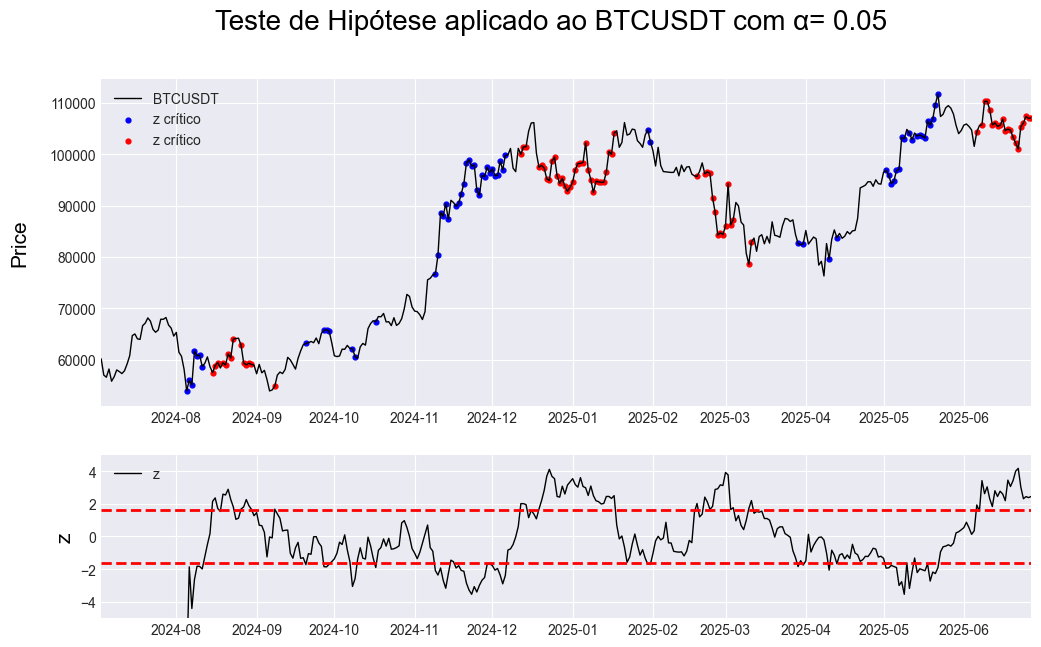

In [11]:
fig =  plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1],  hspace=0.2) # define a proporção de altura dos subplots

ax0 = fig.add_subplot(gs[0]) # primeiro subplot
ax1 = fig.add_subplot(gs[1]) # segundo subplot 
axs = [ax0, ax1] # lista de eixos para facilitar o acesso

# Plotando o gráfico de preços e o valor z
axs[0].plot(df1.index, df1['Close'], color='black', label= TICKER, linewidth=1)

axs[0].scatter(df1.index, np.where(df1['z'].values < X_CRIT_2, df1['Close'], np.nan),
            color="blue", label='z crítico', s=12)   
axs[0].scatter(df1.index, np.where(df1['z'].values > X_CRIT_1, df1['Close'], np.nan),
            color='red', label='z crítico', s=12)

axs[0].set_ylabel('Price', fontsize=15, color='black', labelpad=15)
axs[0].legend()
axs[0].grid(True)  


axs[1].plot(df1.index, df1['z'], color='black', label='z', linewidth=1)
axs[1].axhline(y=X_CRIT_1, color="red", linestyle='--', linewidth=2 )
axs[1].axhline(y=X_CRIT_2, color='red', linestyle='--',    linewidth=2)    
axs[1].set_ylabel("z", fontsize=15, color='black')
axs[1].legend()
axs[1].grid(True)

# Estabelecendo os limites para o eixo y do segundo gráfico - Para melhorar a visualização
axs[1].set_ylim(-5,5)

# Fixando as legendas no canto superior esquerdo
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')

# Alinhando os gráficos - estabelecendo os mesmos limites para o eixo x
axs[0].set_xlim(df1.index.min(), df1.index.max())  
axs[1].set_xlim(df1.index.min(), df1.index.max()) 


# Layout 
fig.tight_layout()
fig.suptitle(f'Teste de Hipótese aplicado ao {TICKER} com α= {ALPHA}', fontsize=20, color='black')
fig.show()